In [327]:
import Pkg; Pkg.activate(".")

  Activating project at `~/SAFT_ML`


In [2]:
using Revise

# Equations of state
using Clapeyron
includet("./saftvrmienn.jl")
import Clapeyron: a_res

# Generating molecular feature vectors
using RDKitMinimalLib 

# Machine learning
using Flux
using ForwardDiff, DiffResults
using Zygote, ChainRulesCore

# Misc
using Statistics, Random, Plots

Random.seed!(1234)

TaskLocalRNG()

In [3]:
m = SAFTVRMie(["propane"])
m.params.segment

SingleParam{Float64}("segment") with 1 component:
 "propane" => 1.6845

In [168]:
function differentiable_saft(X::AbstractVector{T}, Vol, Temp, Mw) where {T<:Real}
    model = SAFTVRMieNN(
        params=SAFTVRMieNNParams(
            Mw=[Mw],
            segment=T[X[1]],
            sigma=T[X[2]] * 1e-10,
            lambda_a=T[6.0], # Fixing at 6
            lambda_r=T[X[3]],
            epsilon=T[X[4]],
            epsilon_assoc=T[],
            bondvol=T[],
        )
    )
    return a_res(model, Vol, Temp, T[1.0])
end
X_nom_meth = Float32[1.0, 3.737, 12.504, 152.58]
@show a = differentiable_saft(X_nom_meth, 1e-4, 300.0, 16.04)
typeof(a)

a = differentiable_saft(X_nom_meth, 0.0001, 300.0, 16.04) = -0.2883850541317945


Float64

In [147]:
function ChainRulesCore.rrule(::typeof(differentiable_saft), x, V, T, Mw)
    y = differentiable_saft(x, V, T, Mw)

    function f_pullback(Δy)
        # Use ForwardDiff to compute the gradient
        #* @thunk means derivatives only computed when needed
        ∂x = @thunk(ForwardDiff.gradient(x -> differentiable_saft(x, V, T, Mw), x) .* Δy)
        ∂V = @thunk(ForwardDiff.derivative(V -> differentiable_saft(x, V, T, Mw), V) * Δy)
        ∂T = @thunk(ForwardDiff.derivative(T -> differentiable_saft(x, V, T, Mw), T) * Δy)
        ∂Mw = @thunk(ForwardDiff.derivative(Mw -> differentiable_saft(x, V, T, Mw), Mw) * Δy)
        return (NoTangent(), ∂x, ∂V, ∂T, ∂Mw)
    end

    return y, f_pullback
end

# Test the gradient computation
# Zygote.gradient(X -> differentiable_saft(X, 1e-4, 300.0), X_nom_meth)
@show Zygote.gradient(x -> differentiable_saft(x, 1e-4, 300.0, 16.04), X_nom_meth)
@show ForwardDiff.gradient(x -> differentiable_saft(x, 1e-4, 300.0, 16.04), X_nom_meth)
nothing

Zygote.gradient((x->begin
            #= /home/luc/SAFT_ML/2_simple_nn.ipynb:19 =#
            differentiable_saft(x, 0.0001, 300.0, 16.04)
        end), X_nom_meth) = (Float32[-0.57261235, -1.2769672f9, 0.05369835, -0.0064937947],)
ForwardDiff.gradient((x->begin
            #= /home/luc/SAFT_ML/2_simple_nn.ipynb:20 =#
            differentiable_saft(x, 0.0001, 300.0, 16.04)
        end), X_nom_meth) = 

[-0.5726123587463587, -1.2769671523779697e9, 0.053698348825390686, -0.006493794844045209]


In [7]:
# Define neural network
#? What inputs should we take
#! Should use inputs from previous ML coursework (ΔG_mix prediction)
model = Chain(
    Dense(2, 10, relu),
    Dense(10, 5, relu),
)

# X are SAFTVRMie parameter predictions
ref_model = GERG2008(["methane"])
ref_a::Float32 = a_res(ref_model, 1e-4, 300.0, [1.0])
function test_loss(X)
    a = differentiable_saft(X, 1e-4, 300.0, 16.04)
    return (a - ref_a)^2
end

model(Float32[1.3, 1.0])

5-element Vector{Float32}:
 0.0
 0.122603744
 0.7758782
 0.0
 1.6340438

test_loss(X_nom_meth) = 0.00010405798606232517


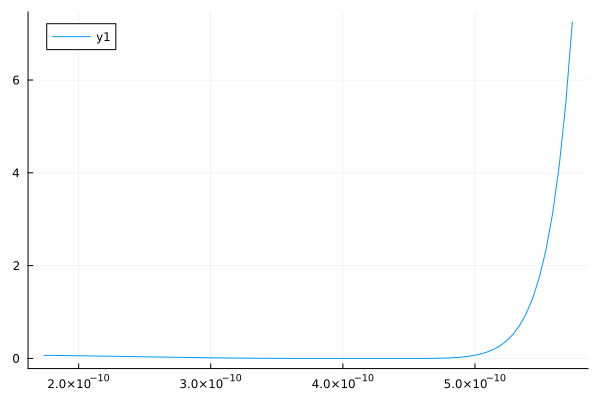

In [8]:
# Zygote.gradient(test_loss, [3.737e-10, 6.0, 12.504, 152.58])
@show test_loss(X_nom_meth)

x_nom = 3.737e-10
δx = [2e-10, 2e-10]
plot(x -> test_loss([1.0, x, 6.0, 12.504, 152.58]), x_nom-δx[1]:5e-12:x_nom+δx[2])

__Below is a test neural network on random data, to see if the network weights will update__

In [9]:
# Define the unbounded neural network model
model_unbounded = Chain(
    Dense(2, 10, relu),
    Dense(10, 5)
)

# Nominal values
# x_nominal = [3.737e-10, 6.0, 12.504, 152.58]

# Custom barrier function to bound the output within ±n⨯ of the nominal value
function bounded_output(x_nn_output, x_nom, n=0.1)
    return x_nom .+ 0.1 .* x_nom .* tanh.(x_nn_output)
end

# Model with bounded output
bounded_model(x) = bounded_output(model_unbounded(x), X_nom_meth)

bounded_model (generic function with 1 method)

In [10]:
# Initial data: Replace these with your actual input (X) and target (y) data
# Assuming each row in X_data is a 2-element vector that serves as input to the neural network
X_data = rand(Float32, 100, 2)  # 100 samples, each with 2 features
y_data = rand(Float32, 100)  # 100 samples, each with one target value

# Hyperparameters
learning_rate = 0.01
epochs = 10

# Optimizer
opt = ADAM(learning_rate)

# @show Flux.params(model_unbounded)
# Training Loop
for epoch in 1:epochs
    loss_vec = []
    for (i, X) in enumerate(eachrow(X_data))
        # X = X_data[i, :]
        y_nom = y_data[i]

        # Compute the loss
        #! Make sure loss is only computed once
        loss_fn() = begin
            # Forward pass through the neural network to get SAFT parameter predictions
            X_pred = bounded_model(X)
            a = differentiable_saft(X_pred, 1e-4, 300.0, 16.04)
            (a - y_nom)^2
        end
        # loss_fn(X_pred)

        append!(loss_vec, loss_fn())
        
        # Compute gradients
        grads = Zygote.gradient(Flux.params(model_unbounded)) do
            loss_fn()
        end
        # @show grads.params
        # grads = Zygote.gradient(loss_fn)

        # Update model parameters
        Flux.update!(opt, Flux.params(model_unbounded), grads)
    end
    # You can add validation and logging here
    println("Epoch: $epoch, Loss: $(mean(loss_vec))")
end

Epoch: 1, Loss: 0.5389303073046404
Epoch: 2, Loss: 0.4318184319454522
Epoch: 3, Loss: 0.4196387896255734
Epoch: 4, Loss: 0.3808746032317356


Epoch: 5, Loss: 0.38036883218051476
Epoch: 6, Loss: 0.380196848373042
Epoch: 7, Loss: 0.38010733161182464
Epoch: 8, Loss: 0.38005361456191233


Epoch: 9, Loss: 0.3800184164458855
Epoch: 10, Loss: 0.3799939185796158


It trains! Now it's time to set up a real dataset. We're going to be generating data from GERG2008, which provides highly accurate data for the following species:

Hydrocarbons:
- methane
- ethane
- propane
- butane
- isobutane
- pentane
- isopentane
- hexane
- heptane
- octane
- nonane
- decane

Elemental molecules:
- helium
- argon
- oxygen
- nitrogen
- hydrogen

Gases
- carbondioxide
- carbonmonoxide
- hydrogensulfide

Water, the only associating compound
- water #! We won't include water


The _y_ data will be the residual helmholtz free energy, a_res, sampled in a range of V, T space. Initially, I'm sampling between 0.5 and 1.5 of the critical point.

__TO CHECK LATER:__
- The GERG2008 equations of state will have published validity ranges. These must be respected.
- Potentially the ideal model used within GERG should be considered if trying to fit to heat capacity data, or similar. Check what properties the heat capacity influences.

In [336]:
# Initially sample data for hydrocarbons
#! isobutane, isopentane not defined for SAFTVRMie
species = [
    "methane",
    # "ethane",
    # "propane",
    # "butane",
    # "isobutane",
    # "pentane",
    # "isopentane",
    # "hexane",
    # "heptane",
    # "octane",
    # "nonane",
    # "decane",
]

# Define smiles map
smiles_map = Dict(
    "methane" => "C",
    "ethane" => "CC",
    "propane" => "CCC",
    "butane" => "CCCC",
    "isobutane" => "CC(C)C",
    "pentane" => "CCCCC",
    "isopentane" => "CC(C)CC",
    "hexane" => "CCCCCC",
    "heptane" => "CCCCCCC",
    "octane" => "CCCCCCCC",
    "nonane" => "CCCCCCCCC",
    "decane" => "CCCCCCCCCC",
)

function make_fingerprint(s::String)::Vector{Float32}
    mol = get_mol(s)
    @assert !isnothing(mol)

    fp = []
    fp_details = Dict{String,Any}("nBits" => 128, "radius" => 1)
    fp_str = get_morgan_fp(mol, fp_details)
    append!(fp, [parse(Float32, string(c)) for c in fp_str])

    # fp_details = Dict{String,Any}("nBits" => 128, "radius" => 3)
    # fp_str = get_morgan_fp(mol, fp_details)
    # append!(fp, [parse(Float32, string(c)) for c in fp_str])

    # Additional descriptors
    desc = get_descriptors(mol)
    # sort by key
    desc = sort(collect(desc), by=x->x[1])
    append!(fp, [x[2] for x in desc])

    return fp
end

# X data contains fingerprint, V, T
# Y data contains a_res
#* Sampling data along saturation curve
T = Float32
X_data = Vector{Tuple{Vector{T},T,T, String}}([])
Y_data = Vector{Vector{T}}()

n = 100
for s in species
    # model = GERG2008([s])
    model = SAFTVRMie([s])
    Tc, pc, Vc = crit_pure(model)
    smiles = smiles_map[s]

    fingerprint = make_fingerprint(smiles)

    T_range = range(0.5 * Tc, 0.99 * Tc, n)
    # V_range = range(0.5 * Vc, 1.5 * Vc, n) # V could be sampled from a logspace
    for T in T_range
        (p₀, V_vec...) = saturation_pressure(model, T)
        for V in V_vec
            push!(X_data, (fingerprint, V, T, s))
            a = a_res(model, V, T, [1.0])
            push!(Y_data, Float32[a])
        end
    end
end

# Randomly shuffle data
#? Split into train, validation set too?
# Generate a set of shuffled indices
# shuffled_indices = shuffle(1:length(X_data))
idx = collect(range(1, length(X_data)))
shuffle!(idx)

# Rearrange X_data and y_data according to the shuffled indices
X_data = X_data[idx]
Y_data = Y_data[idx]

@show size(X_data), X_data[1]
@show size(Y_data), Y_data[1]
nothing

(size(X_data), X_data[1]) = ((200,), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6361, 6.731, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.043, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0313, 0.0, 0.0, 0.0, 0.0, 8.73925, 0.0, 0.0, 0.0], 0.00045937405f0, 169.31277f0, "methane"))
(size(Y_data), Y_data[1]) = ((200,), Flo

In [337]:
mol = get_mol("CCCCC")
# Additional descriptors
desc = get_descriptors(mol)
# sort by key
desc = sort(collect(desc), by=x->x[1])

43-element Vector{Pair{String, Any}}:
             "CrippenClogP" => 2.1965
                "CrippenMR" => 25.19899
             "FractionCSP3" => 1.0
 "NumAliphaticHeterocycles" => 0.0
        "NumAliphaticRings" => 0.0
            "NumAmideBonds" => 0.0
  "NumAromaticHeterocycles" => 0.0
         "NumAromaticRings" => 0.0
     "NumAtomStereoCenters" => 0.0
                 "NumAtoms" => 17.0
                            ⋮
                  "exactmw" => 72.0939
            "hallKierAlpha" => 0.0
                   "kappa1" => 5.0
                   "kappa2" => 4.0
                   "kappa3" => 4.0
                "labuteASA" => 34.19901
              "lipinskiHBA" => 0.0
              "lipinskiHBD" => 0.0
                     "tpsa" => 0.0

In [338]:
# Generate nominal X dictionary
nominal_X = Dict{String,Vector{Float32}}()
for s in species
    model = SAFTVRMie([s])

    nominal_X[s] = [
        model.params.segment[1],
        model.params.sigma[1]*1e10,
        # model.params.lambda_a[1],
        model.params.lambda_r[1],
        model.params.epsilon[1],
    ]
end
nominal_X #! Looks like lambda_a should be fixed at 6.0

Dict{String, Vector{Float32}} with 1 entry:
  "methane" => [1.0, 3.737, 12.504, 152.58]

In [339]:
Mw_dict = Dict{String,Float32}()
for s in species
    model = SAFTVRMie([s])

    Mw_dict[s] = model.params.Mw[1]
end
Mw_dict

Dict{String, Float32} with 1 entry:
  "methane" => 16.04

In [349]:
# Define the unbounded neural network model
input_dim = length(X_data[1][1])
hidden_dim = 256
output_dim = 4

# Using relu activation function for now
num_layers = 2
layers = vcat(
    [Dense(input_dim, hidden_dim, tanh),],
    [Dense(hidden_dim, hidden_dim, tanh) for _ in 1:num_layers],
    [Dense(hidden_dim, output_dim)],
)

# Scaling factor needed for sigma
# sf = [1.0, 1e-10, 1.0, 1.0]
# unbounded_model = x -> sf .* Chain(layers...)(x)
unbounded_model = Chain(layers...)

# Custom barrier function to bound the output within ±n⨯ of the nominal value while keeping derivatives
# https://www.desmos.com/calculator/wpabjptlup
# https://www.desmos.com/calculator/j6rjs1pmjj

# segment=T[X[1]],
# sigma=T[X[2]],
# lambda_a=T[X[3]], #! Fixed at 6.0
# lambda_r=T[X[3]],
# epsilon=T[X[4]],

#! Bounds from ML_SAFT paper
bounds = Vector{Tuple{Float32,Float32}}([
    # (1, 1.1), # m
    # (3.7, 3.75), # σ
    # (12.5, 12.6), # λ
    # (150, 155), # ϵ
    (1, 5), # m
    (2.5, 5), # σ
    (10, 15), # λ
    (100, 1000), # ϵ
])

lb = first.(bounds)
ub = last.(bounds)

# function bounded_output(x_nn_output, x_nom, n=0.5, b=4.5)
#     return @. x_nom - n * x_nom * tanh(-1/b * (x_nn_output - x_nom))
# end
function bounded_output(x_nn_output, b=10.0)
    return @. lb + (ub - lb) * 0.5 * (tanh(1/b * (x_nn_output - lb) / (ub - lb)) + 1)
end

# Model with bounded output
# bounded_model(x, x_nom) = bounded_output(unbounded_model(x), x_nom)
bounded_model(x, x_nom) = bounded_output(unbounded_model(x))

# Hyperparameters
learning_rate = 1e-2
epochs = 20

# Optimizer
opt = ADAM(learning_rate)

println("Beginning iterations, initial model performance:")

fp, V, T, s = X_data[1]
Mw = Mw_dict[s]
y = Y_data[1]

@show s, V, T, Mw

Tp = Float64
X_nom = Vector{Tp}(nominal_X[s])
@show X_nom
X_unbounded = Vector{Tp}(unbounded_model(fp))
@show X_unbounded
X_bounded = Vector{Tp}(bounded_model(fp, X_nom))
@show X_bounded
ŷ = differentiable_saft(X_bounded, V, T, Mw)
@show ŷ, y

loss_vec = []
mean_loss_vec = Float32[]
# Training Loop
#! I think I should be splitting my data into batches, evaluating that batch, then stepping my optimizer?
#! Rather than evaluating each sample individually
for epoch in 1:epochs
    epoch_loss_vec = Float32[]
    epoch_percent_loss_vec = Float32[]
    for (X, y) in zip(X_data, Y_data)
        # Split X into fingerprint, V, T
        fp, V, T, s = X
        X_nom = nominal_X[s]
        Mw = Mw_dict[s]

        y = y[1]

        # Compute the loss
        #! Make sure loss is only computed once
        loss = nothing
        loss_fn() = begin
            # Forward pass through the neural network to get SAFT parameter predictions
            #! nominal X is used to bound the output
            X_pred = bounded_model(fp, X_nom)
            ŷ = differentiable_saft(X_pred, V, T, Mw)
            loss = ((ŷ - y) / y)^2
        end

        # Compute gradients
        grads = Zygote.gradient(Flux.params(unbounded_model)) do
            loss_fn()
        end

        @assert loss isa Real "Loss is not a real number, got $(typeof(loss))"

        append!(epoch_loss_vec, loss)
        append!(epoch_percent_loss_vec, 100 * sqrt(loss))

        # Update model parameters
        Flux.update!(opt, Flux.params(unbounded_model), grads)
    end
    mean_loss = mean(epoch_loss_vec)
    mean_percent_loss = mean(epoch_percent_loss_vec)
    append!(loss_vec, epoch_loss_vec)
    append!(mean_loss_vec, mean_loss)

    if epoch in [1, 2, 3, 4, 5, 10] || epoch % 5 == 0 || epoch == epochs
        println("Epoch: $epoch, Loss: (μ=$mean_loss, σ=$(std(epoch_loss_vec))), Percent Error: $mean_percent_loss")
    end
end

fp, V, T, s = X_data[1]
Mw = Mw_dict[s]
y = Y_data[1]

@show s, V, T, Mw

Tp = Float64
X_nom = Vector{Tp}(nominal_X[s])
@show X_nom
X_unbounded = Vector{Tp}(unbounded_model(fp))
@show X_unbounded
X_bounded = Vector{Tp}(bounded_model(fp, X_nom))
@show X_bounded
ŷ = differentiable_saft(X_bounded, V, T, Mw)
@show ŷ, y

Beginning iterations, initial model performance:
(s, V, T, Mw) = ("methane", 0.00045937405f0, 169.31277f0, 16.04f0)
X_nom = [1.0, 3.736999988555908, 12.503999710083008, 152.5800018310547]
X_unbounded = [-0.7637674808502197, -0.05542983114719391, 0.7714713215827942, 0.5930972695350647]
X_bounded = [2.9118687363487696, 3.622671651920782, 12.043742820535034, 545.029856805655]
(ŷ, y) = (-68.79830713093354, Float32[-0.26908025])
Epoch: 1, Loss: (μ=749.6332, σ=5153.7485), Percent Error: 1558.361


Epoch: 2, Loss: (μ=63.862686, σ=54.764095), Percent Error: 758.9551


Epoch: 3, Loss: (μ=35.39262, σ=27.601288), Percent Error: 568.89136


Epoch: 4, Loss: (μ=24.104038, σ=17.60424), Percent Error: 470.97195


Epoch: 5, Loss: (μ=18.163286, σ=13.033544), Percent Error: 408.71106


Epoch: 10, Loss: (μ=7.463163, σ=5.501924), Percent Error: 259.87494


Epoch: 15, Loss: (μ=4.528267, σ=3.0650249), Percent Error: 203.13524


Epoch: 20, Loss: (μ=3.3562794, σ=2.0380628), Percent Error: 175.92432


(s, V, T, Mw) = ("methane", 0.00045937405f0, 169.31277f0, 16.04f0)
X_nom = [1.0, 3.736999988555908, 12.503999710083008, 152.5800018310547]
X_unbounded = [-118.50627136230469, -47.33353042602539, 97.3459701538086, -193.3191680908203]
X_bounded = [1.0101370658141184, 2.5455573760341372, 14.852559776745352, 535.339232754694]
(ŷ, y) = (-0.6140903500964445, Float32[-0.26908025])


(-0.6140903500964445, Float32[-0.26908025])

In [350]:
n = 19
fp, V, T, s = X_data[n]
y = Y_data[n]
Mw = Mw_dict[s]

Tp = Float64

X_nom = Vector{Tp}(nominal_X[s])
X_unbounded = Vector{Tp}(unbounded_model(fp))
X_bounded = Vector{Tp}(bounded_model(fp, X_nom))
ŷ = differentiable_saft(X_bounded, V, T, Mw)

@show s, V, T, Mw
@show X_nom
@show X_unbounded
@show X_bounded
@show ŷ, y

nothing

(s, V, T, Mw) = ("methane", 4.867996f-5, 164.47583f0, 16.04f0)
X_nom = [1.0, 3.736999988555908, 12.503999710083008, 152.5800018310547]
X_unbounded = [-118.50627136230469, -47.33353042602539, 97.3459701538086, -193.3191680908203]
X_bounded = [1.0101370658141184, 2.5455573760341372, 14.852559776745352, 535.339232754694]
(ŷ, y) = (-5.838994574405424, Float32[-1.9674051])


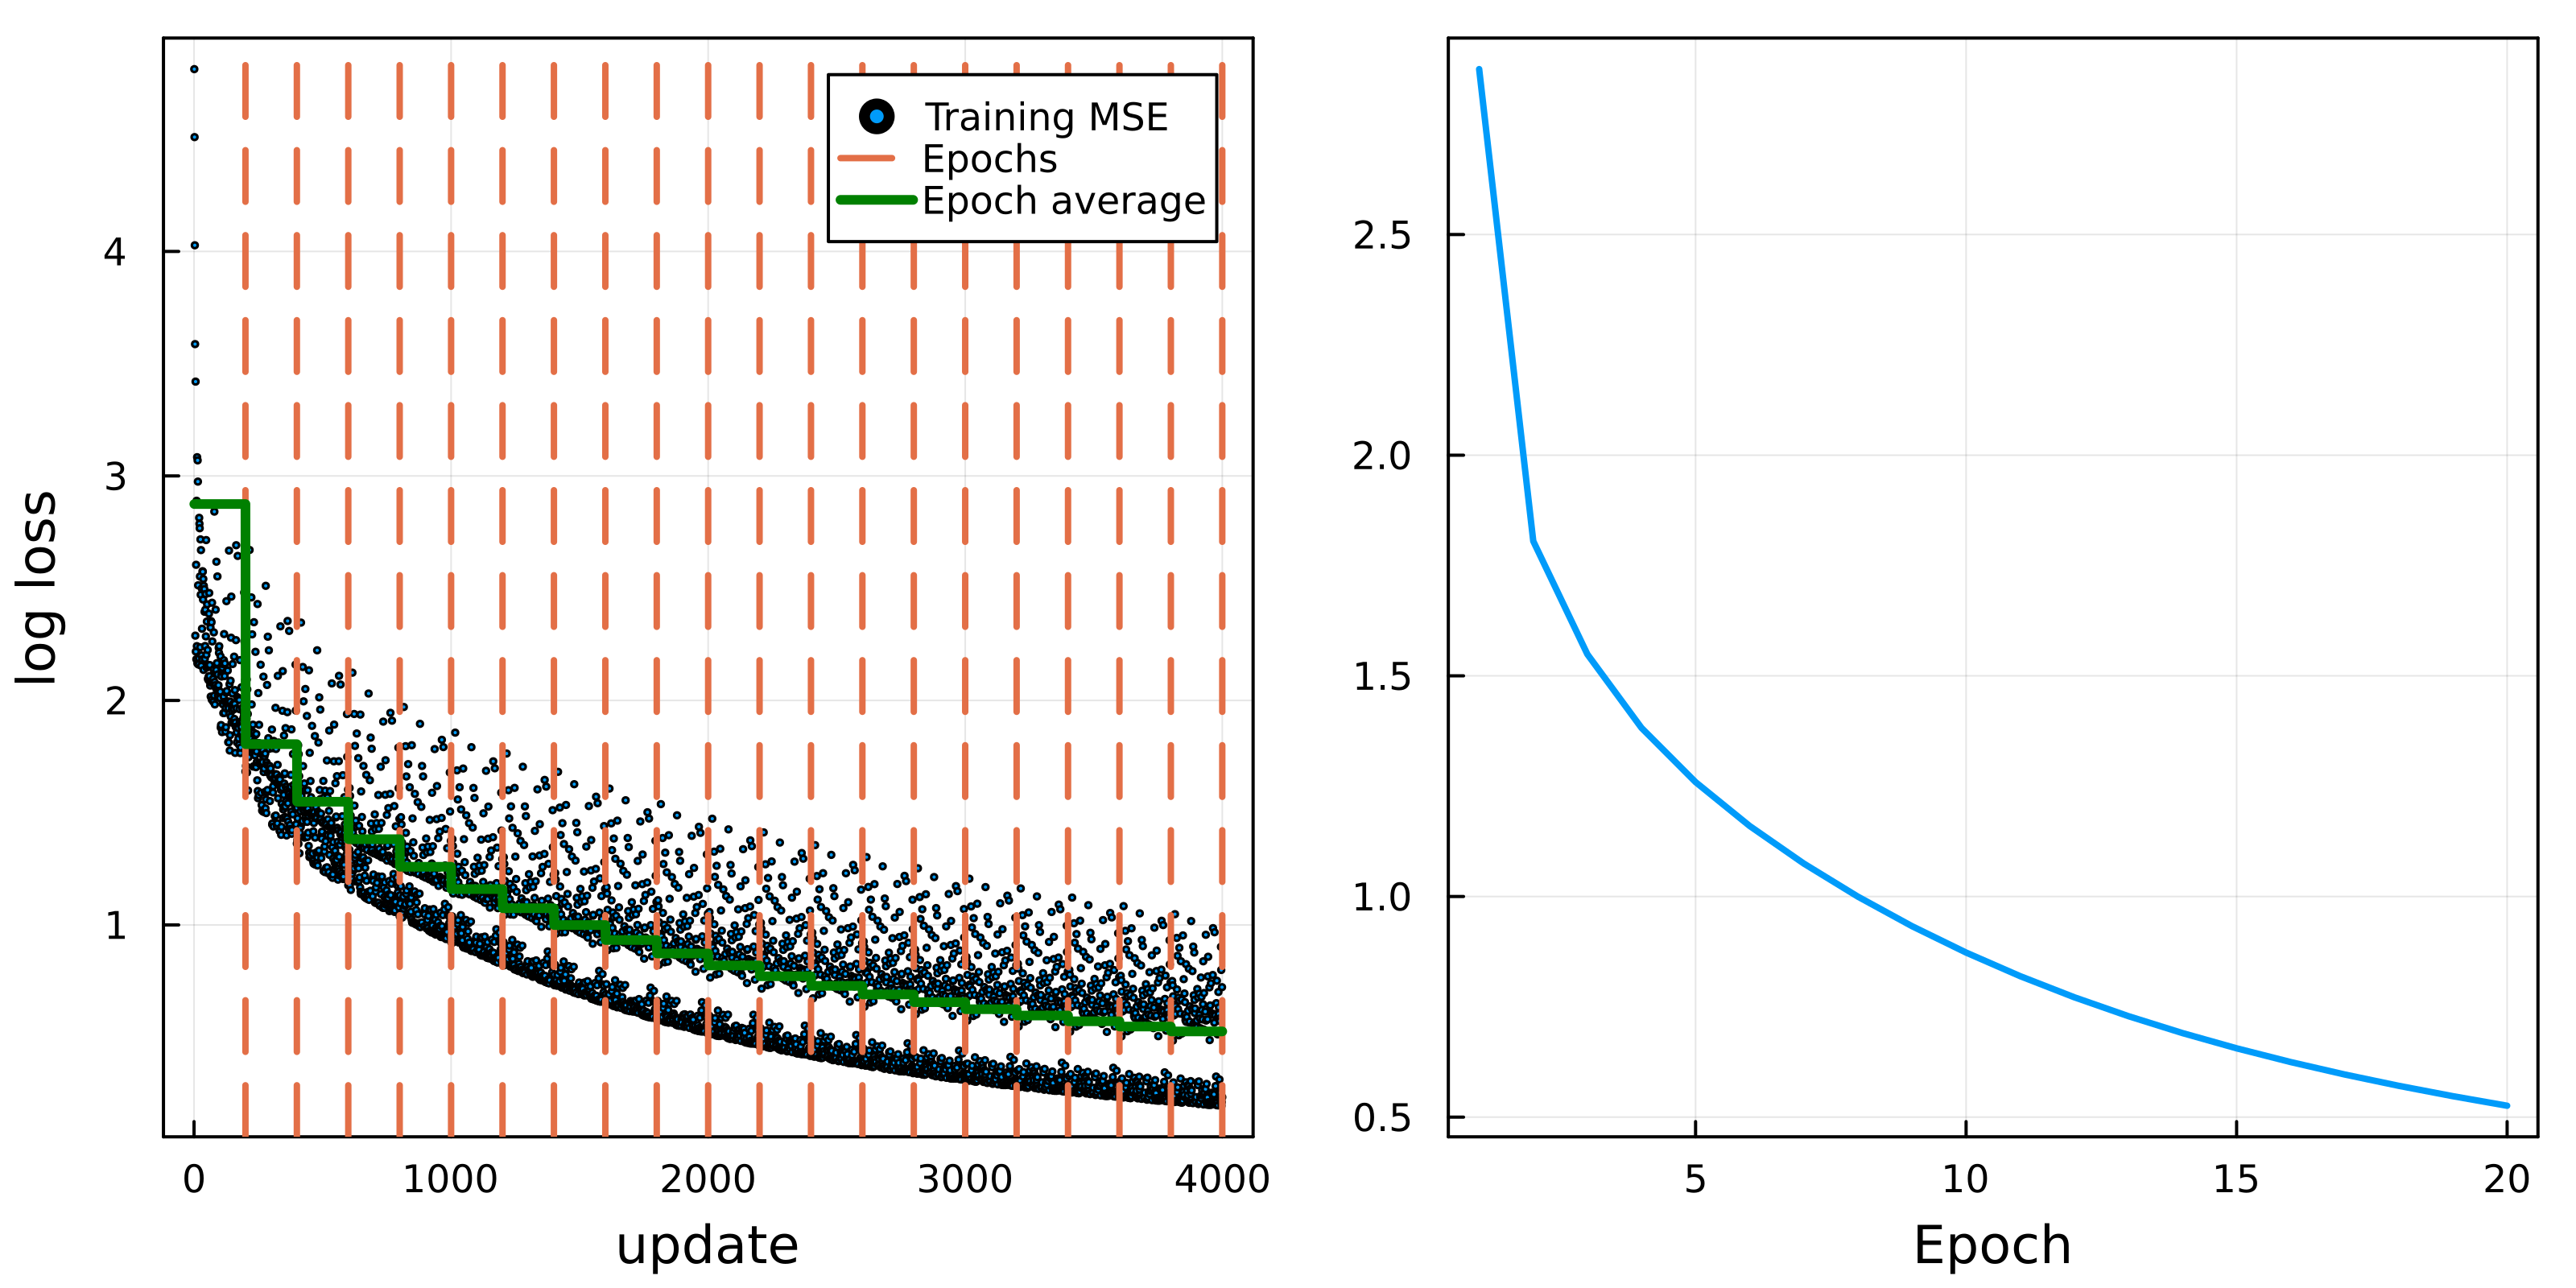

In [351]:
plot1 = scatter(log10.(loss_vec), xlabel="update", ylabel="log loss", label="Training MSE", lw=0, box=:on, ms=1.0, dpi=400)
vline!([i for i in 1:length(loss_vec) if i % length(X_data) == 0], label="Epochs", lw=2, ls=:dash)

# Duplicate mean_loss_vec so that it has the same length as loss_vec
# This is duplicated so the first value is repeated n times, then the second value is repeated n times, etc.

mean_loss_vec_long = Float32[]
for (i, loss) in enumerate(mean_loss_vec)
    append!(mean_loss_vec_long, [loss for _ in 1:length(X_data)])
end

plot!(log10.(mean_loss_vec_long), label="Epoch average", lw=3, color=:green)

plot2 = plot(1:epochs, log10.(mean_loss_vec), xlabel="Epoch", ylabel="", label="", lw=2, box=:on)

plot(plot1, plot2, layout = (1, 2), size = (800, 400), left_margin = 3Plots.mm, bottom_margin = 3Plots.mm)